 Apply Grover to $$|\psi_0\rangle = \sum_{i=1}^M \frac{1}{\sqrt{M}} |i-1\rangle |\psi(x_i, \theta^*)\rangle$$

into $$|\upsilon\rangle = \sum_{i \in \text{sv}} \frac{1}{\sqrt{m_s}} |i-1\rangle |\psi(x_i, \theta^*)\rangle$$

In [31]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Parameters
M = 8
ms = 2
marked_indices = [0, 4]
n_qubits = int(np.ceil(np.log2(M)))

In [33]:
states_basis = [format(i, f'0{n_qubits}b') for i in range(M)]
states_basis

['000', '001', '010', '011', '100', '101', '110', '111']

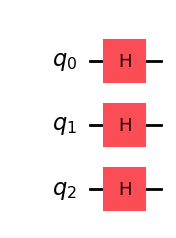

In [34]:
# Initialize |psi0>
def initialize_psi0(n_qubits):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

qc_psi0 = initialize_psi0(n_qubits)
qc_psi0.draw('mpl')

Statevector([0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
             0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
             0.35355339+0.j, 0.35355339+0.j],
            dims=(2, 2, 2))


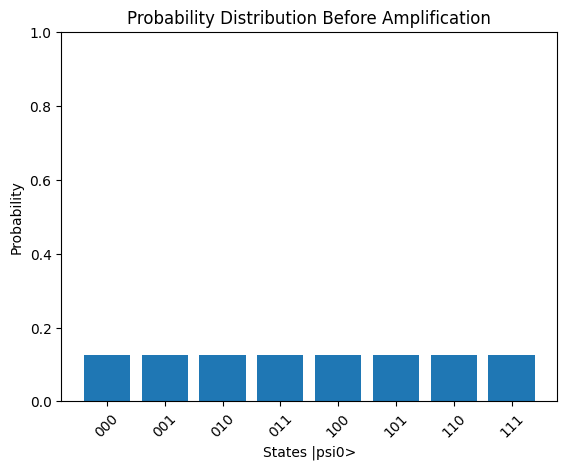

In [35]:
state_psi0 = Statevector.from_instruction(qc_psi0)
print(state_psi0)
probs_psi0 = np.abs(state_psi0.data)**2

plt.bar(states_basis, probs_psi0[:M])
plt.xticks(rotation=45)
plt.ylim([0.0, 1.0])
plt.xlabel('States |psi0>')
plt.ylabel('Probability')
plt.title('Probability Distribution Before Amplification')
plt.show()

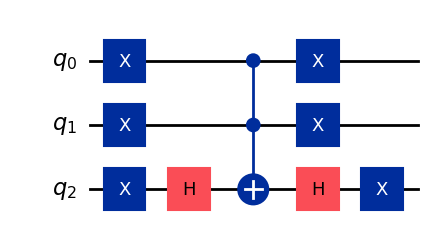

In [36]:
# Define Oracle (Phase Inversion Operator - Oracle)
def oracle(qc, marked_indices, n_qubits):
    for idx in marked_indices:
        # Convert index to binary
        binary = format(idx, f'0{n_qubits}b')[::-1]

        # Apply X for 0 bits
        for i, bit in enumerate(binary):
            if bit == '0':
                qc.x(i)

        # Multi-controlled Z
        if n_qubits > 1:
            qc.h(n_qubits - 1)
            qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            qc.h(n_qubits - 1)
        else:
            qc.z(0)

        # Unapply X
        for i, bit in enumerate(binary):
            if bit == '0':
                qc.x(i)
    

# # Example
oracle_qc = QuantumCircuit(n_qubits)
oracle(oracle_qc, [0], n_qubits)
oracle_qc.draw('mpl')

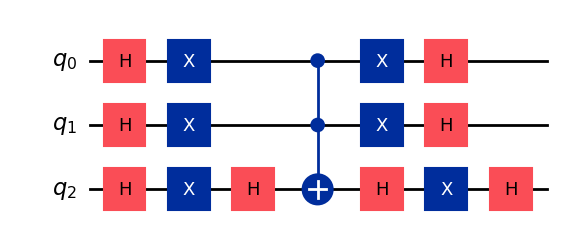

In [37]:
# Define Diffusion O = 2|psi><psi| - I
def diffusion(qc, n_qubits):
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    if n_qubits > 1:
        qc.h(n_qubits - 1)
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        qc.h(n_qubits - 1)
    else:
        qc.z(0)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))


# Example
diffusion_qc = QuantumCircuit(n_qubits)
diffusion(diffusion_qc, n_qubits)
diffusion_qc.draw('mpl')


In [38]:
# Calculate R
def calculate_R(ms, M):
    theta = np.arcsin(np.sqrt(ms / M))
    R = int(np.round(np.pi / (4 * theta) - 0.5))
    print(f'Theta: {theta:.4f}, R: {R}')
    return R

R = calculate_R(ms, M)

Theta: 0.5236, R: 1


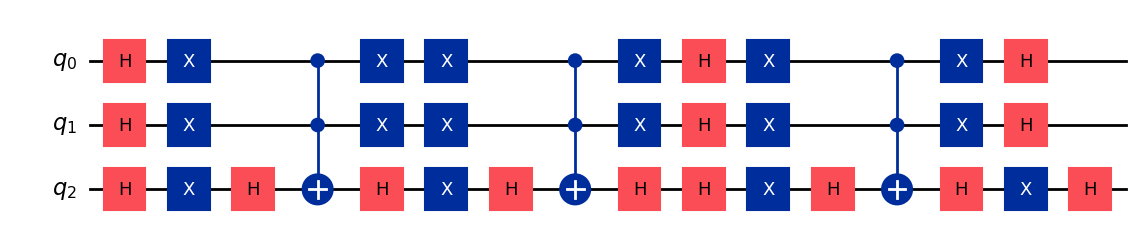

In [39]:
# Apply Grover operator G = O * T
qc = qc_psi0.copy()
for _ in range(R):
    oracle(qc, marked_indices, n_qubits)
    diffusion(qc, n_qubits)

qc.draw('mpl')

In [40]:
# Simulate statevector
state = Statevector.from_instruction(qc)
probs = np.abs(state.data)**2

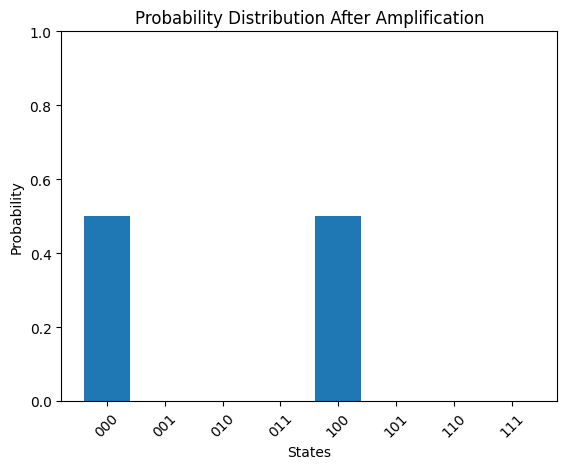

In [41]:
plt.bar(states_basis, probs[:M])
plt.xticks(rotation=45)
plt.ylim([0.0, 1.0])
plt.xlabel('States')
plt.ylabel('Probability')
plt.title('Probability Distribution After Amplification')
plt.show()

In [42]:
print(f'Probability of marked states: {sum(probs[i] for i in marked_indices):.4f}')
print(f'Probabilities: {probs[:M]}')

Probability of marked states: 1.0000
Probabilities: [5.00000000e-01 4.08197406e-34 1.04305010e-35 6.60468735e-67
 5.00000000e-01 4.08197406e-34 1.04305010e-35 6.60468735e-67]
